# Modeling

- Last observed value
- Simple average
- Moving average
- Holt's Linear Trend
- Previous cycle

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# wrangle
#import acquire
import prepare

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

# facebook prophet model
#from prophet import Prophet

# local files
import prepare

# Wrangle

In [2]:
df = pd.read_csv('youtube_data_updated_date.csv')

In [3]:
df.shape

(15730, 9)

In [4]:
df = prepare.prep_youtube(df)

In [5]:
df = df[df.pub_date != '#VALUE!']

In [6]:
df.date = pd.to_datetime(df.pub_date, utc = True)
df.set_index('pub_date', inplace =True)
df.sort_index(inplace=True);

In [7]:
# trim off date range
#df = df[df.index>='2021-09-30']
#df = df[df.index<='2022-09-10']

In [8]:
df.index = pd.to_datetime(df.index, errors='coerce', utc=True)

In [9]:
df = df[df.index>='09/30/21']
df = df[df.index<='09/10/22']

In [10]:
df = df.viewCount

In [11]:
df= pd.DataFrame(df)

In [12]:
df.rename(columns = {'viewCount':'views'}, inplace=True)

In [13]:
# resample on day
resample = df.resample('m')['views'].sum()

In [14]:
resample = pd.DataFrame(resample)

In [15]:
resample.head()

,views
pub_date,
2021-10-31 00:00:00+00:00,1402854610
2021-11-30 00:00:00+00:00,1063427351
2021-12-31 00:00:00+00:00,785746049
2022-01-31 00:00:00+00:00,740140465
2022-02-28 00:00:00+00:00,1692483741


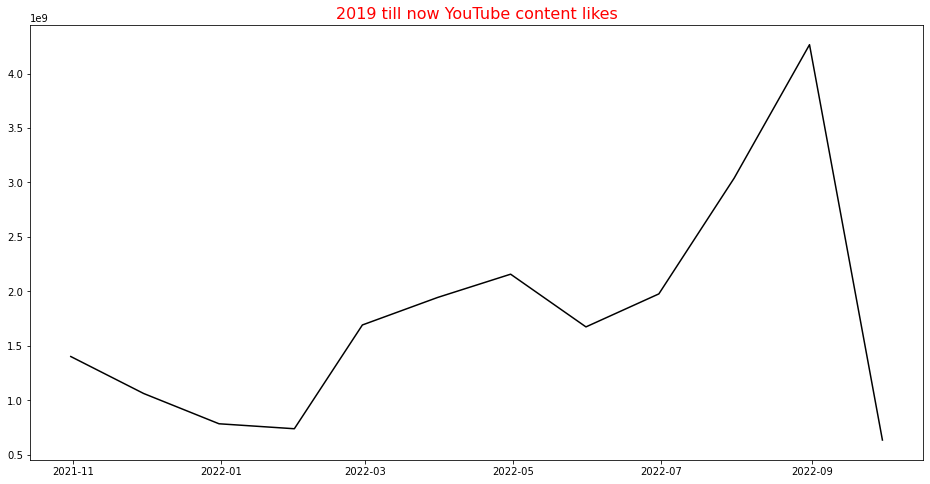

In [16]:
#views
plt.figure(figsize = (16,8))
plt.title('2019 till now YouTube content likes', fontsize = 16, color = 'red')
plt.plot(resample.index, resample.views, color = 'black')

# Split Data

- We will use the training proportion method to split.
- Identify the total length of the dataframe and multiply by train_prop to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data. (x = train_prop * 100)
- Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.
- Return train and test dataframes.

In [17]:
# check df size
resample.shape

(12, 1)

In [18]:
# set train size to be 50% of total 
train_size = int(round(resample.shape[0] * 0.5))
train_size

6

In [19]:
# set validate size to be 30% of total 
validate_size = int(round(resample.shape[0] * 0.3))
validate_size

4

In [20]:
# set test size to be number of rows remaining. 
test_size = int(round(resample.shape[0] * 0.2))
test_size

2

In [21]:
len(resample) == train_size + validate_size + test_size

True

In [22]:
# validate will go from 689 to 689+413
validate_end_index = train_size + validate_size
validate_end_index

10

**NOTE: Use above values to split our dataframe**

In [23]:
# train will go from 0 to 689
train = resample[:train_size]

In [24]:
# validate will go from 690 to 1102
validate = resample[train_size:validate_end_index]

In [25]:
# verify train tail and validate head
train.tail()

,views
pub_date,
2021-11-30 00:00:00+00:00,1063427351
2021-12-31 00:00:00+00:00,785746049
2022-01-31 00:00:00+00:00,740140465
2022-02-28 00:00:00+00:00,1692483741
2022-03-31 00:00:00+00:00,1945147661


In [26]:
# verify train tail and validate head
validate.head()

,views
pub_date,
2022-04-30 00:00:00+00:00,2158388277
2022-05-31 00:00:00+00:00,1674703941
2022-06-30 00:00:00+00:00,1977567477
2022-07-31 00:00:00+00:00,3040194574


In [27]:
# verify validate tail and test head
validate.tail()

,views
pub_date,
2022-04-30 00:00:00+00:00,2158388277
2022-05-31 00:00:00+00:00,1674703941
2022-06-30 00:00:00+00:00,1977567477
2022-07-31 00:00:00+00:00,3040194574


In [28]:
# test will include 1103 to the end
test = resample[validate_end_index:]

In [29]:
# verify validate tail and test head
test.head()

,views
pub_date,
2022-08-31 00:00:00+00:00,4264402349
2022-09-30 00:00:00+00:00,636536208


In [30]:
# check size
train.shape[0], validate.shape[0], test.shape[0]

(6, 4, 2)

## Verify Split

- Does the length of each df equate to the length of the original df?

In [31]:
# is len of train + validate + test == lenght of entire dataframe. 
len(train) + len(validate) + len(test) == len(resample)

True

- Does the first row of original df equate to the first row of train?

In [32]:
print(resample.head(1) == train.head(1))

                           views
pub_date                        
2021-10-31 00:00:00+00:00   True


- Is the last row of train the day before the first row of validate? And the same for validate to test?

In [33]:
# verified
pd.concat([train.tail(1), validate.head(1)])

,views
pub_date,
2022-03-31 00:00:00+00:00,1945147661
2022-04-30 00:00:00+00:00,2158388277


In [34]:
# verifed
pd.concat([validate.tail(1), test.head(1)])

,views
pub_date,
2022-07-31 00:00:00+00:00,3040194574
2022-08-31 00:00:00+00:00,4264402349


- Is the last row of test the same as the last row of our original dataframe?

In [35]:
pd.concat([test.tail(1), resample.tail(1)])

,views
pub_date,
2022-09-30 00:00:00+00:00,636536208
2022-09-30 00:00:00+00:00,636536208


### Let's plot our data, viewing where the data is split into train and test.

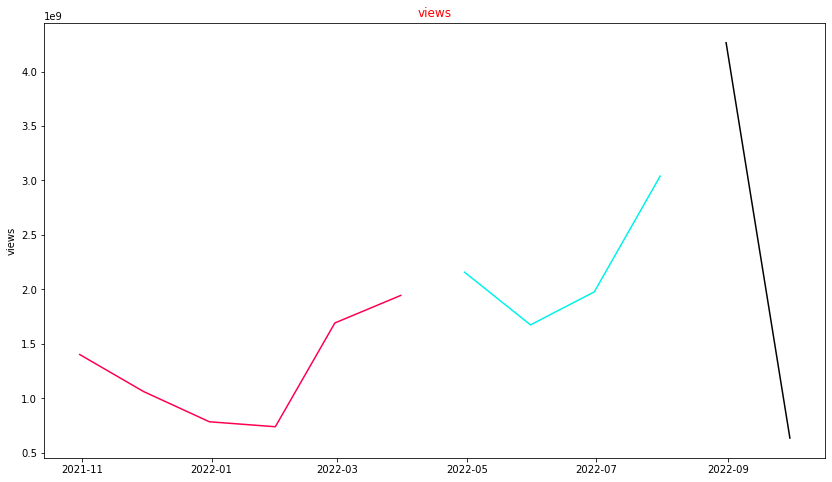

In [36]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color = '#ff0050')
    plt.plot(validate[col], color = '#00f2ea')
    plt.plot(test[col], color = '#000000')
    plt.ylabel(col)
    plt.title(col, color = 'red')
    plt.show()

# Evaluation Functions

In [37]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [38]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

Write `append_eval_df(model_type)` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our `eval_df` data frame object. Which we will create an empty `eval_df` dataframe object to start.

In [39]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [40]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [41]:
def make_predictions(views=None, likes=None):
    yhat_df = pd.DataFrame({'views': [views]},
                          index=validate.index)
    return yhat_df

# Forecasting

- Last Observed Value (Baseline)
- Moving Average: The future will look, on average, like recent history.
- Holt's Linear Trend
- Previous Cycle
- Facebook Prophet

## Baseline

#### Views

In [42]:
train['views'][-1:][0]

1945147661

In [43]:
# take thb last item of sales total and assign to variable
last_views = train['views'][-1:][0]
last_views

1945147661

In [44]:
yhat_df = pd.DataFrame(
    {'views': [last_views]},
    index=validate.index)

yhat_df.head()

,views
pub_date,
2022-04-30 00:00:00+00:00,1945147661
2022-05-31 00:00:00+00:00,1945147661
2022-06-30 00:00:00+00:00,1945147661
2022-07-31 00:00:00+00:00,1945147661


#### Plot Actual vs. Predicted Values

views -- RMSE: 574192945


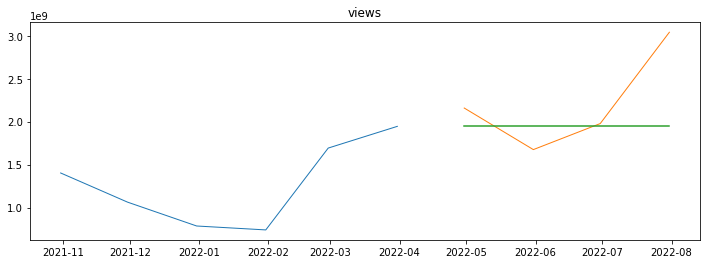

In [45]:
plot_and_eval('views')

#### Evaluate

In [46]:
for col in train[['views']]:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,views,574192945.0


In [47]:
min_views_rmse = eval_df[eval_df.target_var == 'views']['rmse'].min()
min_views_rmse

574192945.0

## Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value.

In [48]:
# print(train['views'].rolling(30).mean())

#### Make Predictions

In [49]:
# period=30
# train['views'].rolling(period).mean()[-1]

In [50]:
# period = 30 

# # take 30 day rolling average, then take the last element and that will the one that propogates 
# # forward as our prediction. 
# rolling_views = round(train['views'].rolling(period).mean()[-1], 2)
# #rolling_likes = round(train['likes'].rolling(period).mean()[-1], 2)
# print(rolling_views)

In [51]:
# yhat_df = make_predictions(rolling_views)
# yhat_df.head()

#### Plot Actual vs. Predicted Values

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

In [52]:
# train.head()

In [53]:
# plot_and_eval('views')

#### Evaluate

In [54]:
# eval_df = append_eval_df(model_type = '30d_moving_avg', target_var = 'views')

# eval_df

Let's try out several other values for periods:

In [55]:
# periods = [4, 12, 26, 52, 104]

# for p in periods: 
#     rolling_sales = round(train['views'].rolling(p).mean()[-1], 2)
#     #rolling_quantity = round(train['likes'].rolling(p).mean()[-1], 2)
#     yhat_df = make_predictions(rolling_views)
#     model_type = str(p) + '_day_moving_avg'
#     eval_df = append_eval_df(model_type = model_type,
#                                 target_var = 'views')

In [56]:
# # which is best so far?
# eval_df

In [57]:
# # min rmse for views
# min_views_rmse = eval_df[eval_df.target_var == 'views']['rmse'].min()

In [58]:
# min_views_rmse

In [59]:
# eval_df[eval_df.rmse == min_views_rmse]

## Holt's Linear Trend

In [60]:
col = 'views' 
# create our Holt's Object
model = Holt(train[col], exponential=False, damped=True)

In [61]:
# fit the holt's object
model = model.fit(optimized=True)

In [62]:
col = 'views'
model = Holt(train[col], exponential=False, damped=True)
model = model.fit(optimized=True)
yhat_items = model.predict(start = validate.index[0],
                          end = validate.index[-1])
yhat_df[col] = round(yhat_items, 2)

#### Plot Actual vs. Predicted Values

views -- RMSE: 657173669


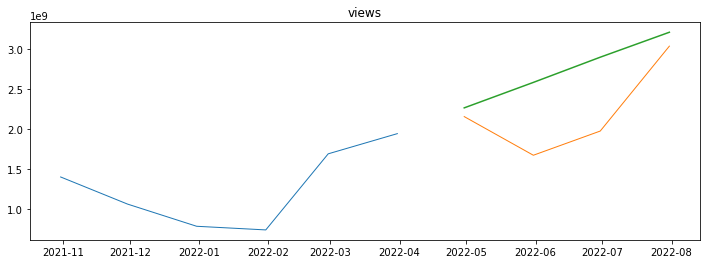

In [63]:
#for col in train['views']:
plot_and_eval(target_var = col)

#### Evaluate

In [64]:
#for col in train['views']:
eval_df = append_eval_df(model_type = 'holts_optimized', target_var = col)

In [65]:
eval_df[eval_df.target_var =='views'].sort_values(by='rmse').head(10)

,model_type,target_var,rmse
0,last_observed_value,views,574192945.0
1,holts_optimized,views,657173669.0


## Facebook Prophet

In [66]:
fb_train = pd.DataFrame({'ds':train.index, 'y': train.views})

In [67]:
m = Prophet(changepoint_range=0.75,changepoint_prior_scale=0.75)
m.fit(fb_train)

NameError: name 'Prophet' is not defined

In [ ]:
validate.index

In [ ]:
future = m.make_future_dataframe(periods = 59, freq = 'W')
future.tail()

In [ ]:
# make prediction
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# plot the forecast
m.plot(forecast)

In [ ]:
# trend, yearly seasonality, and weekly seasonality of the time series
m.plot_components(forecast)

In [ ]:
# interactive figure of the forecast and components
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)


In [ ]:
plot_components_plotly(m, forecast)

In [ ]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
add_changepoints_to_plot(fig.gca(),m,forecast)

In [ ]:
validate.shape

In [ ]:
train.shape

In [ ]:
forecast.shape

In [ ]:
rmse = round(sqrt(mean_squared_error(validate['views'], forecast['yhat'].tail(59))), 0)
rmse

## Autoregressive Integrated Moving Average (ARIMA)

- First parameter:  the lagging (past values)
- Second parameter:  differencing (this is what makes non-stationary data stationary)
- Last parameter: white noise (for modeling shock events). 

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

## LSTM Neural Network

## XGBoost

#### Basic Model Resample by Day (2018-12-01 - 2022-09-10)
- Baseline Views RMSE: 120066387

- Rolling Average RMSE: 120259456

- Facebook Prophet Views: 109683655 (outperform by 8.6%)

#### Basic Model Resample by Week (2018-12-01 - 2022-09-10)
- Baseline Views RMSE: 599773169
- Rolling Average RMSE: 599773169
- Holt's RMSE: 349329760
- Facebook: 322011088 (46.3%)
    - weekly_seasonality=False, changepoint_range=1,changepoint_prior_scale=0.75 464053600
    - weekly_seasonality=False, changepoint_range=1,changepoint_prior_scale=0.5 365801236
    - weekly_seasonality=False, changepoint_range=0.5,changepoint_prior_scale=0.75 323347218
    - weekly_seasonality=False, changepoint_range=0.3,changepoint_prior_scale=0.5 354942242
    - weekly_seasonality=False, changepoint_range=0.5,changepoint_prior_scale=0.5 618014950

In [ ]:
(599773169-322011088)/599773169